In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 


sns.set_style('whitegrid')
%matplotlib inline

In [43]:
mapper= pd.read_csv('data_files/mapper.csv')
full_mapper= pd.read_csv('data_files/full_mapper.csv')
final_reviews= pd.read_csv('data_files/yelp_reviews_with_period.csv')

In [13]:
cats= pd.read_csv('/Users/dspitzfaden/Galvanize/capstone/data_files/categories_from_sql.csv')

In [44]:
final_reviews= final_reviews[final_reviews['inspection_grade']!= 'X']
final_reviews= final_reviews[final_reviews['inspection_grade']!= 'O']
final_reviews= final_reviews[final_reviews['inspection_grade']!= 'P']
grades = final_reviews[['yelp_business_id', 'inspection_date', 'last_inspection', 'inspection_grade']].reset_index().sort_values(['yelp_business_id', 'inspection_date', 'last_inspection'])
grades = grades.drop('index', axis=1)
grades = grades.drop_duplicates(subset=['yelp_business_id', 'inspection_date', 'last_inspection'])
grouped_text= final_reviews.groupby(['yelp_business_id', 'inspection_date', 'last_inspection'])['yelp_review_text'].apply(lambda x: "{%s}" % '~~ '.join(x)).reset_index().sort_values(['yelp_business_id', 'inspection_date', 'last_inspection'])
grouped_w_grades= grades.merge(grouped_text, left_on=['yelp_business_id', 'inspection_date', 'last_inspection'], right_on=['yelp_business_id', 'inspection_date', 'last_inspection'])
merged_cats = mapper.merge(cats, left_on='id', right_on= 'id')
final_reviews['B'] = np.where(final_reviews['inspection_grade']== 'B', 1, 0)
final_reviews['C'] = np.where(final_reviews['inspection_grade']== 'C', 1, 0)

In [16]:
stop_words = text.ENGLISH_STOP_WORDS.union(['good food', 'customer service', 'food good', 'really good', 'las vegas', 'service great', 'great food' ])
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, max_features=10000, stop_words='english', ngram_range=(2,3))
transform_count = count_vectorizer.fit_transform(grouped_w_grades['yelp_review_text'].values)
features = count_vectorizer.get_feature_names()

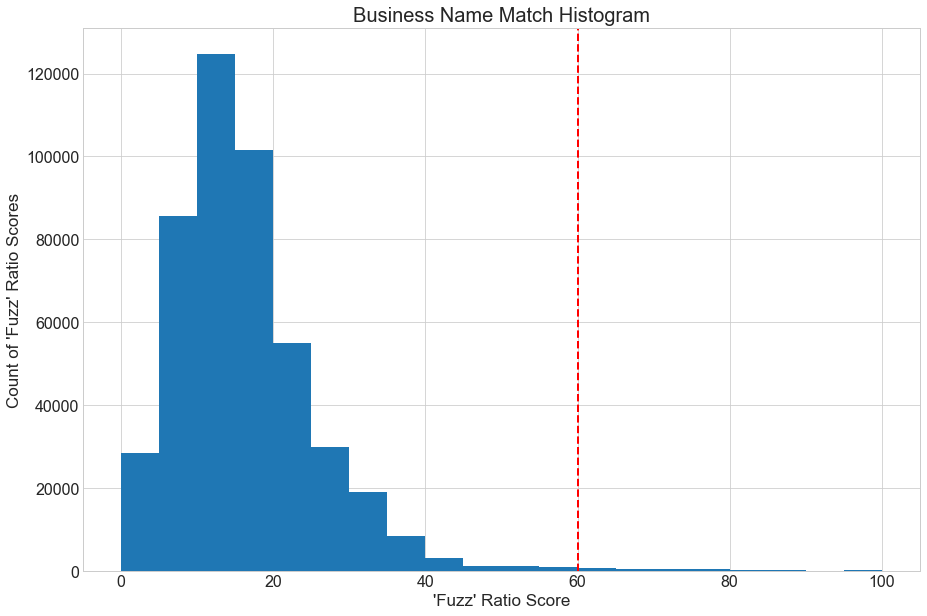

In [22]:
plt.xlabel("'Fuzz' Ratio Score", fontsize=17)
plt.ylabel("Count of 'Fuzz' Ratio Scores", fontsize=17)
plt.title('Business Name Match Histogram', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axvline(x=60, color='r', linestyle='dashed', linewidth=2)
full_mapper['fuzz_ratio'].hist(bins=20, figsize=(15,10))

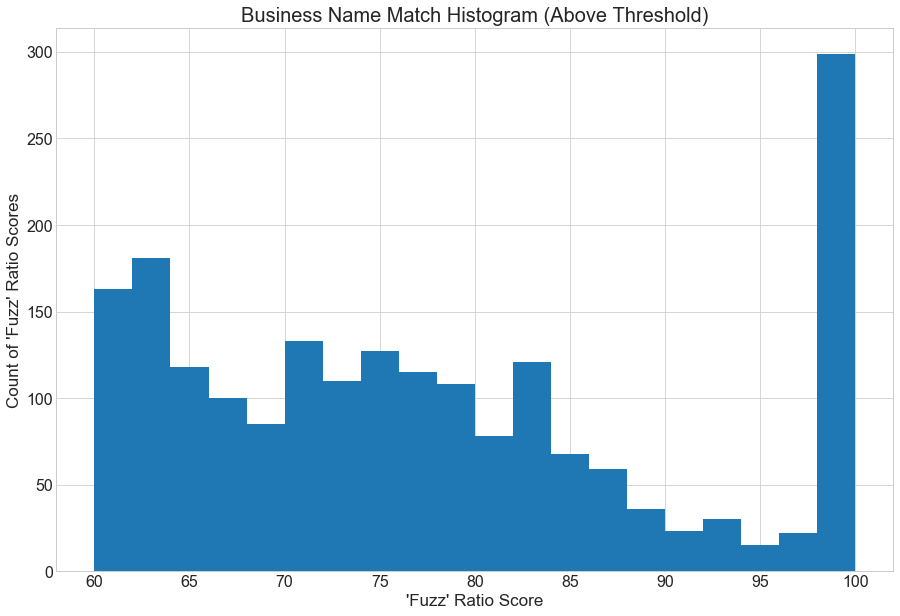

In [23]:
plt.xlabel("'Fuzz' Ratio Score", fontsize=17)
plt.ylabel("Count of 'Fuzz' Ratio Scores", fontsize=17)
plt.title('Business Name Match Histogram (Above Threshold)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
mapper['fuzz_ratio'].hist(bins=20, figsize=(15,10))

(array([0, 1, 2]), <a list of 3 Text yticklabel objects>)

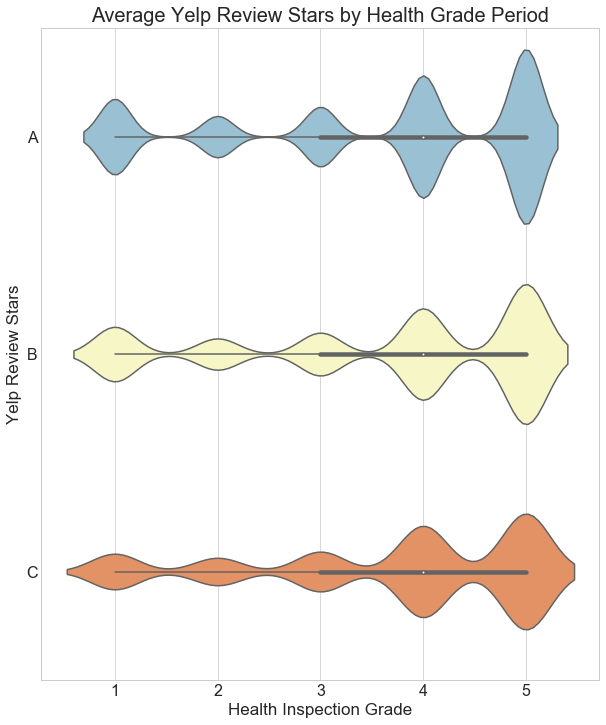

In [24]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(10, 12)
sns.violinplot(y=final_reviews['inspection_grade'],x=final_reviews['yelp_review_stars'], palette="RdYlBu_r")

plt.title('Average Yelp Review Stars by Health Grade Period', fontsize= 20)
plt.xlabel('Health Inspection Grade', fontsize=17)
plt.ylabel('Yelp Review Stars', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [25]:
#i actually used a count vectorizer
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row)'''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=2, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df= feats_df.sort_values('tfidf')
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(20, 17), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Count Vectorizer Score", labelpad=16, fontsize=20)
        ax.set_title("Health Inspection Grade = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
#         ax.set_xlim((0,1))
        yticks = ax.set_yticklabels(df.feature, fontsize=17)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

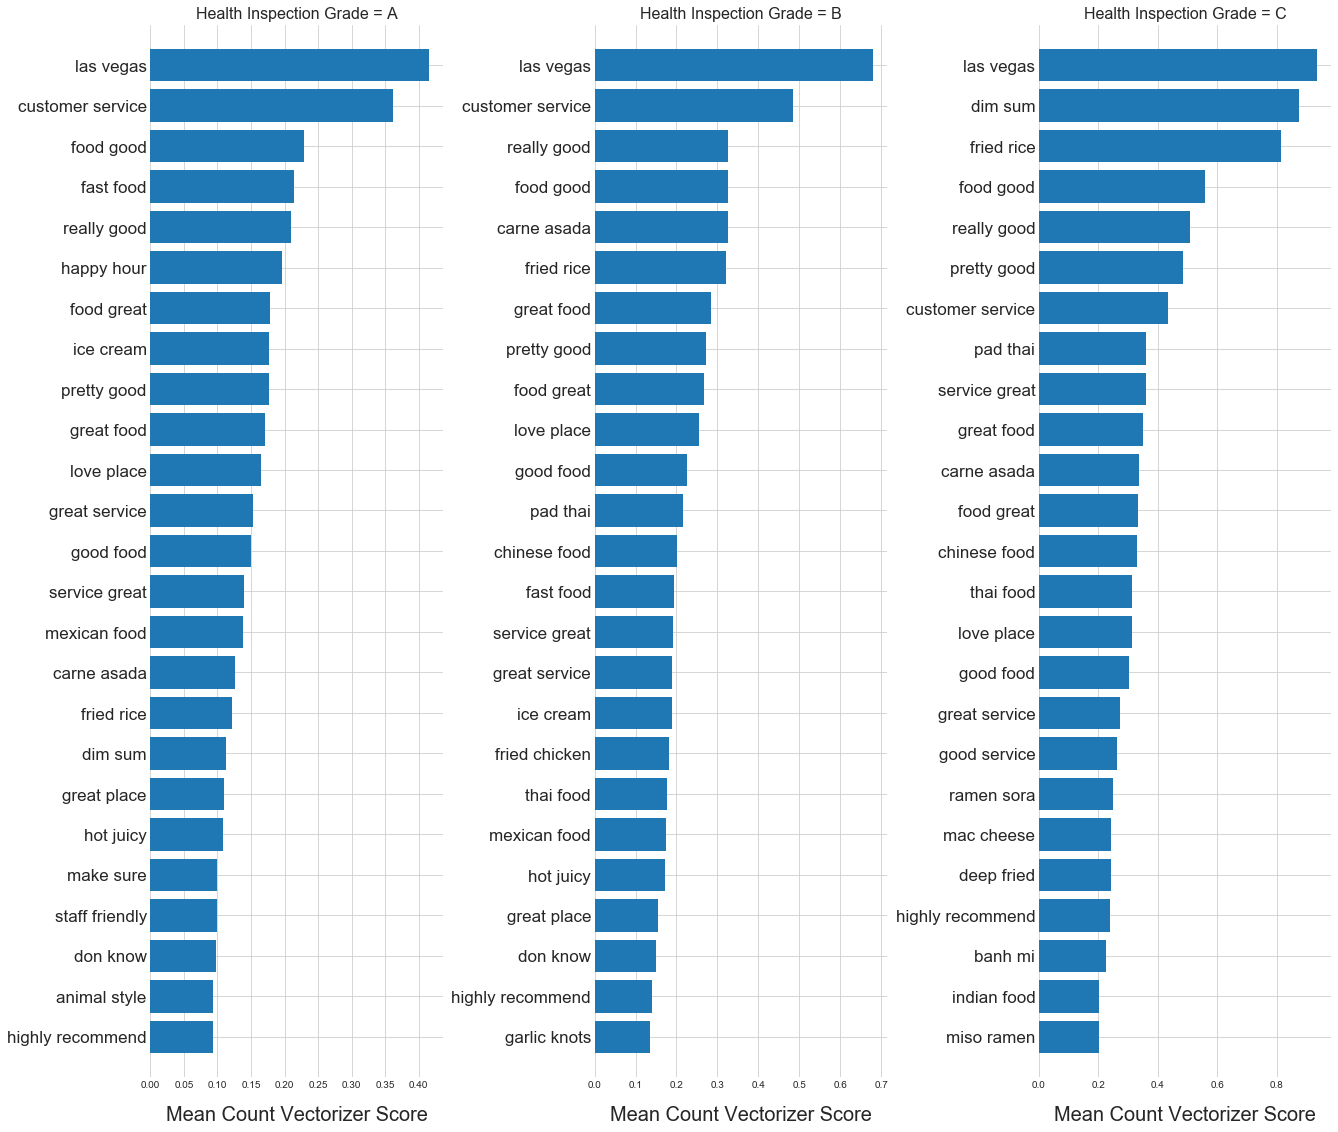

In [26]:
dfs = top_feats_by_class(transform_count, grouped_w_grades['inspection_grade'].values, features, min_tfidf=2, top_n=25)
plot_tfidf_classfeats_h(dfs)

In [27]:
#this should be improved, i just hard-coded data in
raw_data = {'Category': ['Overall','Vietnamese', 'Mexican', 'American (Traditional)', 'Fast Food'],
        'A': [75, 55, 85, 85, 89],
        'B': [18, 24, 14, 12, 10],
        'C': [6, 21, 1, 3, 1]}
df = pd.DataFrame(raw_data, columns = ['Category', 'A', 'B', 'C'])

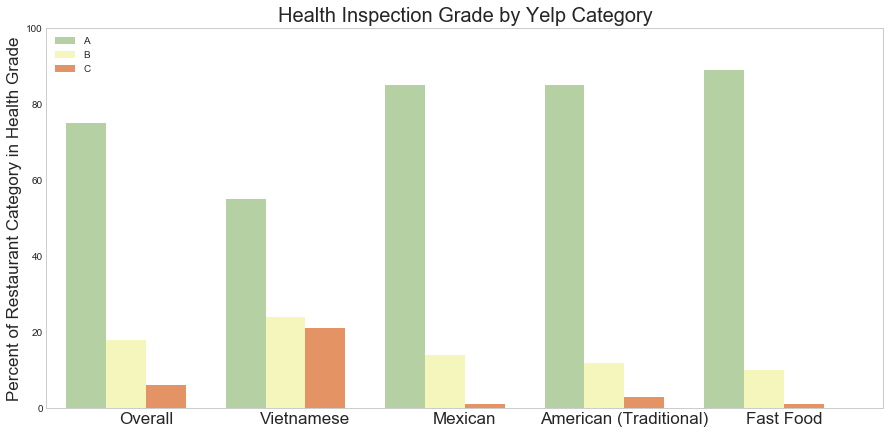

In [28]:
# Setting the positions and width for the bars
pos = list(range(len(df['A']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,7))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['A'], 
        # of width
        width, 
        alpha=.75,
        # with color
        color='#9DC183', 
        # with label the first value in first_name
        label=df['Category'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['B'],
        # of width
        width, 
  
        # with color
        color='#F5F6BC', 
        # with label the second value in first_name
        label=df['Category'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['C'], 
        # of width
        width, 
       
        # with color
        color='#e49464', 
        # with label the third value in first_name
        label=df['Category'][2]) 

# Set the y axis label
ax.set_ylabel('Percent of Restaurant Category in Health Grade', fontsize=17)

# Set the chart's title
ax.set_title('Health Inspection Grade by Yelp Category', fontsize=20)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['Category'], fontsize=17)


# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['A'] + df['B'] + df['C'])] )

# Adding the legend and showing the plot
plt.legend(['A', 'B', 'C'], loc='upper left')
plt.grid()
plt.show()

(0, 6)

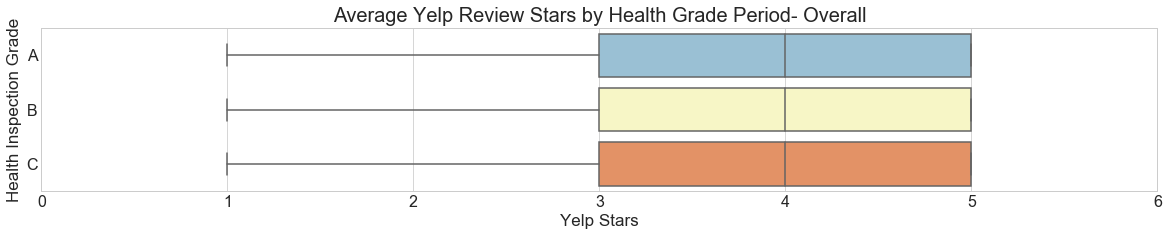

In [29]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20, 3)
sns.boxplot(y=final_reviews['inspection_grade'],x=final_reviews['yelp_review_stars'], palette="RdYlBu_r",orient='h', order= ['A', 'B', 'C'])
plt.title('Average Yelp Review Stars by Health Grade Period- Overall', fontsize= 20)
plt.xlabel('Yelp Stars', fontsize=17)
plt.ylabel('Health Inspection Grade', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim((0,6))

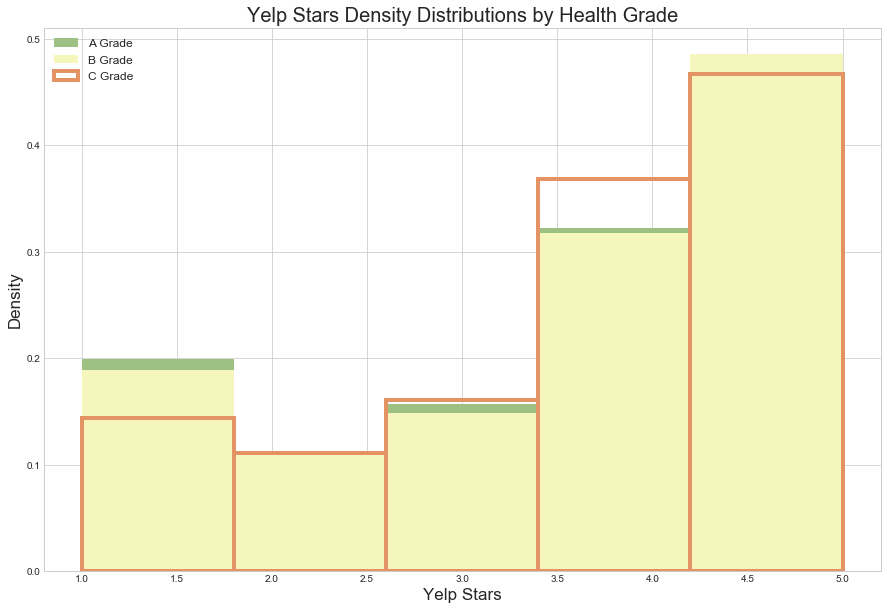

In [45]:
a_df = final_reviews[final_reviews['A']==1]
b_df = final_reviews[final_reviews['B']==1]
c_df = final_reviews[final_reviews['C']==1]

plt.figure(figsize=(15,10))
acounts, abins, abars= plt.hist(a_df['yelp_review_stars'], bins=5, normed=True, label= 'A Grade', color='#9DC183')
bcounts, bbins, bbars= plt.hist(b_df['yelp_review_stars'], bins=5, normed=True, label= 'B Grade', color='#F5F6BC')
ccounts, cbins, cbars= plt.hist(c_df['yelp_review_stars'], bins=5, normed=True, label='C Grade',facecolor='None', linewidth=4,edgecolor='#e49464')
plt.title('Yelp Stars Density Distributions by Health Grade', fontsize=20)
plt.xlabel('Yelp Stars', fontsize=17)
plt.ylabel('Density', fontsize=17)
plt.legend(fontsize='large')